## Data Cleaning

In [110]:
# imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
# reading the combined dataset
df = pd.read_csv('subreddit_combined.csv')

In [3]:
# checking the dataset
df.head()

,Unnamed: 0,title,selftext,subreddit
0,0,"Silly Questions Saturday, January 25, 2020",Do you have a question about history and have ...,history
1,1,75 years since Auschwitz: Survivors share stor...,NaN,history
2,2,"Forty five years ago, eight Soviet women climb...",NaN,history
3,3,Why is it so uncommon for U.S. Presidents to c...,It's really quite surprising to me that only 3...,history
4,4,According to a study done by the United States...,[https://encyclopedia.ushmm.org/content/en/ar...,history


In [4]:
# dropping the unnamed column
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
# checking for null 
df.isnull().sum()

title          0
selftext     372
subreddit      0
dtype: int64

In [6]:
# filling null with '' since they're empty texts
df.fillna('', inplace=True)

In [7]:
# verifying the fill
df.isnull().sum()

title        0
selftext     0
subreddit    0
dtype: int64

In [8]:
# combining the title and selftext
df['title_text'] = df['title'] + '' + df['selftext']

In [9]:
# creating a source column where history has value 1 and NoStupidQuestions has value 0
df['source'] = [1 if i == 'history' else 0 for i in df['subreddit']]

In [10]:
# keeping only the relevant columns
df = df[['title_text', 'source']]

In [11]:
# verifying the change
df.head()

,title_text,source
0,"Silly Questions Saturday, January 25, 2020Do y...",1
1,75 years since Auschwitz: Survivors share stor...,1
2,"Forty five years ago, eight Soviet women climb...",1
3,Why is it so uncommon for U.S. Presidents to c...,1
4,According to a study done by the United States...,1


In [12]:
# baseline accuracy
df['source'].value_counts(normalize=True)

1    0.513611
0    0.486389
Name: source, dtype: float64

## Exporting Cleaned Dataset

In [13]:
df.to_csv('subreddit_cleaned.csv')

## Exploratory Data Analysis

In [14]:
# instantiate CountVectorizer
cvec1 = CountVectorizer(stop_words='english')
cvec0 = CountVectorizer(stop_words='english')

In [15]:
# transform the corpus
words1 = cvec1.fit_transform(df[df['source'] == 1]['title_text'])
words0 = cvec0.fit_transform(df[df['source'] == 0]['title_text'])

In [16]:
# putting posts from history into a dataframe
words1 = pd.DataFrame(words1.toarray(), columns=cvec1.get_feature_names())

In [17]:
# putting posts from NoStupidQuestions into a dataframe
words0 = pd.DataFrame(words0.toarray(), columns=cvec0.get_feature_names())

In [18]:
# transposing the dataframe, creating a frequency column then getting the top 20 words in history
words1 = words1.T
words1['frequency'] = words1.sum(axis=1)
words1 = words1.sort_values('frequency',ascending=False)[['frequency']]
words1.head(20)

,frequency
did,609
history,493
like,404
war,395
people,357
know,329
just,317
time,259
https,224
ve,220


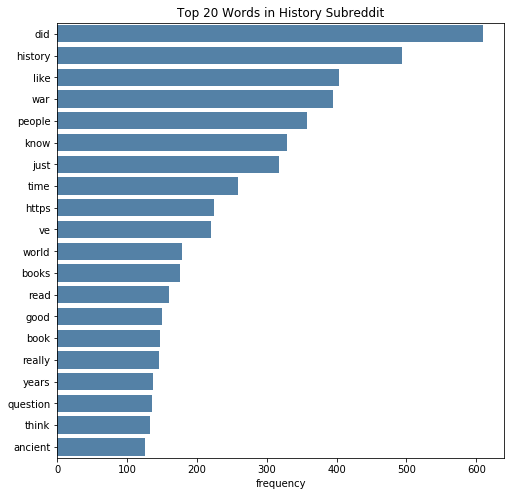

In [19]:
plt.figure(figsize=(8,8))
ax_hist = plt.axes()
ax_hist.set_title(label ="Top 20 Words in History Subreddit")
sns.barplot(x = words1.head(20).frequency ,y = words1.head(20).index, data = words1, color='steelblue')

In [20]:
# transposing the dataframe, creating a frequency column then getting the top 20 words in NoStupidQuestions
words0 = words0.T
words0['frequency'] = words0.sum(axis=1)
words0 = words0.sort_values('frequency',ascending=False)[['frequency']]
words0.head(20)

,frequency
like,335
just,307
people,236
know,178
does,174
don,172
time,120
ve,117
really,105
say,99


(0, 650)

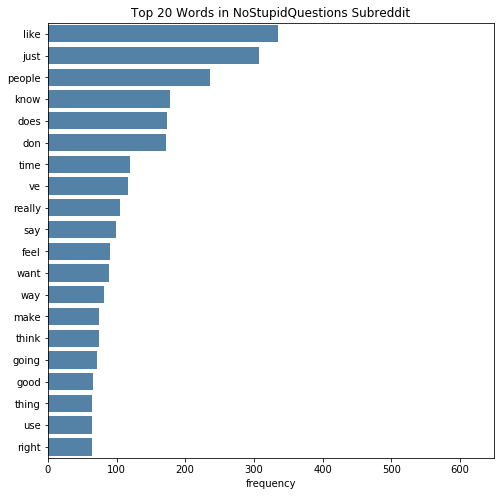

In [21]:
plt.figure(figsize=(8,8))
ax_nsq= plt.axes()
ax_nsq.set_title(label ="Top 20 Words in NoStupidQuestions Subreddit")
sns.barplot(x = words0.head(20).frequency ,y = words0.head(20).index, data = words0, color='steelblue').set_xlim(0,650)

There seems to be a few common words with high occurences in both subreddits such as 'like','just' and 'people'. Since their numbers are pretty high in both History ('like': 404, 'just': 317, 'people': 357}) and NoStupidQuestions ('like': 335, 'just': 307, 'people': 236). It is likely that these words will not be taken into account for classification as inclusion does not offer distinction between the 2 subreddits.

## Preprocessing

In [22]:
X = df['title_text']
y = df['source']

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Model 1: Naive Bayes

In [24]:
# pipeline for naive bayes
pipe_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [25]:
# gridsearch to obtain best parameters
pipe_nb_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs_nb = GridSearchCV(pipe_nb, param_grid=pipe_nb_params, cv=5)
gs_nb.fit(X_train, y_train)
print(gs_nb.best_score_)
gs_nb.best_params_

0.8938356164383562


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [26]:
# scoring on the training set with the best params
gs_nb.score(X_train, y_train)

0.9513698630136986

In [27]:
# scoring on the testing set with the best params
gs_nb.score(X_test, y_test)

0.893223819301848

There is only a small difference between scores on the training set and testing set. This means that there isn't overfitting on the training set. 

In [28]:
# predicting on the testing set 
predictions_nb = gs_nb.predict(X_test)

In [29]:
# confusion matrix between predictions and actual 
confusion_matrix(y_test, predictions_nb)

array([[203,  34],
       [ 18, 232]])

In [30]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_nb).ravel()

In [31]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 203
False Positives: 34
False Negatives: 18
True Positives: 232


In [87]:
# displaying the confusion matrix in a dataframe
cm_nb = pd.DataFrame(confusion_matrix(y_test, predictions_nb),
                     columns = ['Predicted NoStupidQuestions', 'Predicted History'],
                     index = ['Actual NoStupidQuestions', 'Actual History'])
cm_nb

,Predicted NoStupidQuestions,Predicted History
Actual NoStupidQuestions,203,34
Actual History,18,232


## Model 2: Logistic Regression

In [32]:
# pipeline for logistic regresson
pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(solver='lbfgs'))
])

TfidfVectorizer penalises common words while rare words are given more influence during the classification. I have decided to use the TfidfVectorizer here because of the nature of the posts in history, where words like kings and queens appear more often than in regular texts. 

In [33]:
# gridsearch to obtain best parameters
pipe_lr_params = {
    'tvec__max_features': [2500, 3000, 3500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}
gs_lr = GridSearchCV(pipe_lr, param_grid=pipe_lr_params, cv=5)
gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_)
gs_lr.best_params_

0.9102739726027397


{'tvec__max_df': 0.9,
 'tvec__max_features': 3500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [34]:
# scoring on the training set with the best params
gs_lr.score(X_train, y_train)

0.976027397260274

In [35]:
# scoring on the testing set with the best params
gs_lr.score(X_test, y_test)

0.919917864476386

There is only a small difference between scores on the training set and testing set as well for the Logistic model. This means that there isn't overfitting on the training set. 

In [36]:
# predicting on the testing set 
predictions_lr = gs_lr.predict(X_test)

In [37]:
# confusion matrix between predictions and actual 
confusion_matrix(y_test, predictions_lr)

array([[218,  19],
       [ 20, 230]])

In [38]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_lr).ravel()

In [39]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 218
False Positives: 19
False Negatives: 20
True Positives: 230


In [88]:
# displaying the confusion matrix in a dataframe
cm_lr = pd.DataFrame(confusion_matrix(y_test, predictions_lr),
                     columns = ['Predicted NoStupidQuestions', 'Predicted History'],
                     index = ['Actual NoStupidQuestions', 'Actual History'])
cm_lr

,Predicted NoStupidQuestions,Predicted History
Actual NoStupidQuestions,218,19
Actual History,20,230


## Misclassified Posts

We will look at the top features (words) in our misclassified posts to see if we can improve our Logistic model. 

In [40]:
# creating a dataframe to validate results from models vs actual
results = pd.DataFrame(list(y_test), columns=['actual'])
results['predicted_lr'] = predictions_lr

In [41]:
# verifying the dataframe
results.head()

,actual,predicted_lr
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0


In [42]:
# retreiving indices of false positives and false negatives
id_lr_fp = results[(results['predicted_lr'] != results['actual']) & (results['predicted_lr'] == 1)].index
id_lr_fn = results[(results['predicted_lr'] != results['actual']) & (results['predicted_lr'] == 0)].index

In [43]:
# instantiate CountVectorizer
cvec_false = CountVectorizer(stop_words='english')

In [44]:
# transforming the dataset and putting it into a dataframe, verifying the dataframe
words_false = cvec_false.fit_transform(df['title_text'])
words_false = pd.DataFrame(words_false.toarray(), columns=cvec_false.get_feature_names())
words_false.head()

,00,000,00000001,00001,01,018,02,0262042827,0262a,03,...,zupko,zurerinnerung,zwigenberg,ælfweard,æthelstan,école,κωνσταντινούπολις,есүхэй,тэмүүжин,王伦
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# filtering the false positive rows and sorting them according to their frequencies
words_fp = words_false.loc[id_lr_fp].T
words_fp['frequency'] = words_fp.sum(axis=1)
words_fp = words_fp.sort_values('frequency',ascending=False)[['frequency']]

In [46]:
# obtaining the more common words (appearing more than 10 times) in the false positives
words_fp[words_fp['frequency'] >= 10]

,frequency
elephant,11
history,11
king,10
naresuan,10
think,10


In [47]:
# filtering the false negative rows and sorting them according to their frequencies
words_fn = words_false.loc[id_lr_fn].T
words_fn['frequency'] = words_fn.sum(axis=1)
words_fn = words_fn.sort_values('frequency',ascending=False)[['frequency']]

In [48]:
# obtaining the more common words (appearing more than 10 times) in the false negatives
words_fn[words_fn['frequency'] >= 10]

,frequency
history,11
did,10


Let us add the top words from the False Positives and False Negatives into our stop words to see if we can improve our classification scores.

In [49]:
# compiling the common features of the misclassified posts
false_common = ['elephant', 'history', 'king', 'naresuan', 'think', 'did']

In [55]:
# extending our stop words
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(false_common)

In [61]:
# verifying the extension at the end of the list
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Remodeling our Logistic Regression with Extended Stop Words

In [99]:
# pipeline for logistic regresson with extended stop words
pipe_lr_new = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegression(solver='lbfgs'))
])

In [100]:
# gridsearch to obtain best parameters
gs_lr_new = GridSearchCV(pipe_lr_new, param_grid=pipe_lr_params, cv=5)
gs_lr_new.fit(X_train, y_train)
print(gs_lr_new.best_score_)
gs_lr_new.best_params_

0.9047945205479452


{'tvec__max_df': 0.9,
 'tvec__max_features': 3500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [101]:
# scoring on the training set with the best params
gs_lr_new.score(X_train, y_train)

0.9773972602739726

In [102]:
# scoring on the testing set with the best params
gs_lr_new.score(X_test, y_test)

0.9096509240246407

In [103]:
# predicting on the testing set 
predictions_lr_new = gs_lr_new.predict(X_test)

In [104]:
# confusion matrix between predictions and actual 
confusion_matrix(y_test, predictions_lr_new)

array([[213,  24],
       [ 20, 230]])

In [105]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_lr_new).ravel()

In [106]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 213
False Positives: 24
False Negatives: 20
True Positives: 230


In [107]:
# displaying the confusion matrix in a dataframe
cm_lr_new = pd.DataFrame(confusion_matrix(y_test, predictions_lr_new),
                     columns = ['Predicted NoStupidQuestions', 'Predicted History'],
                     index = ['Actual NoStupidQuestions', 'Actual History'])
cm_lr_new

,Predicted NoStupidQuestions,Predicted History
Actual NoStupidQuestions,213,24
Actual History,20,230


## Findings and Conclusion

Between the 2 models, Naive Bayes and Logistic Regression, Logisitic Regression scored better classifying historical texts vs regular texts. Due to the nature of the posts in NoStupidQuestions, it is likely that those posts wrongly predicited as posts in History are posts that could have fit into both subreddits. 

Some examples:    
https://www.reddit.com/r/NoStupidQuestions/comments/ew81hs/if_i_went_back_to_the_1920s_and_contracted_the/
https://www.reddit.com/r/NoStupidQuestions/comments/ew2gmn/if_the_republic_of_china_gave_up_its_claim_over/

Posts like these promote discussions for origins of what happened in the past and may be classified as either threads.

As the accuracy of the new Logistis model has gone down after extending the stop words, I believe that the words, 'elephant', 'history', 'king', 'naresuan', 'think', 'did', were significant in discriminating between the 2 subreddit threads.

In [116]:
# creating dataframe true value and predicted probabilities
pred_proba = [i[1] for i in gs_lr.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
1766,0,0.425664
1476,0,0.367152
1719,0,0.259166
477,1,0.699539
1217,0,0.336758


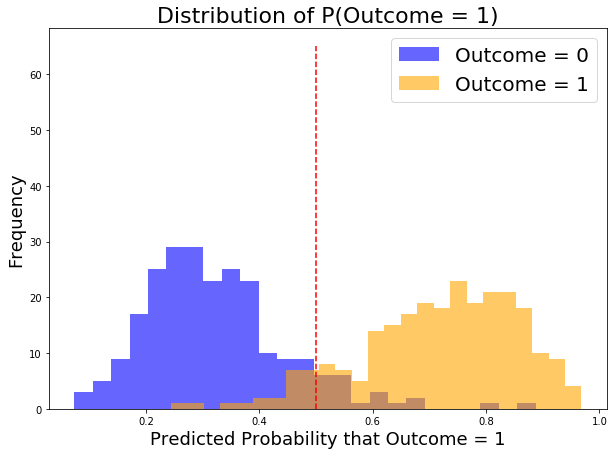

In [119]:
# plotting the spread between the subreddit threads to see the overlap
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

There is a good spread of values against the threshold of 0.5, which is close to the baseline model. This suggests that this model has high accuracy classifying the posts.

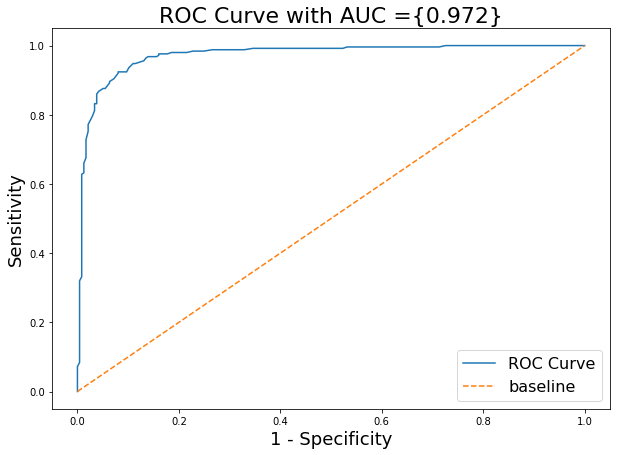

In [120]:
# AUC ROC of logistic regression model with tfidvectorizer
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC =' + str({round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}), fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

The aim is to get the ROC AUC score as close to 1 as possible. The higher the score the better the model is able to separate the 2 different classes. Our Logistic Regression model has a score of 0.972 which suggests a good ability to differentiate both classes. 